## DSCI 552 PS 1 - Used Car Dataset

## Duplicate - scales the target variable `price` in the model

In [1]:
import warnings
warnings.filterwarnings('ignore')

## data preparation and analysis
import pandas as pd 
from pandas.plotting import scatter_matrix
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy as sp 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

## modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
## import custom function to get feature names
from helper import get_feature_names

In [3]:
df = pd.read_csv(r'../data/used_car_dataset.csv')
print(df.shape)

(9997, 14)


In [4]:
df.head(3)

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type,paint_color,F1,F2,F3,F4
0,21978.0,2016.0,ford,like new,6 cylinders,gas,80813.0,automatic,SUV,black,138,2.472286,0.059031,b
1,4185.0,2008.0,ford,good,8 cylinders,gas,201800.0,automatic,SUV,white,415,2.285245,0.046328,c
2,7693.0,2002.0,ford,excellent,6 cylinders,gas,145000.0,automatic,pickup,white,535,1.861461,0.158554,b


In [5]:
# df.describe()

In [6]:
# ## 14 attributes
# df.info()

# EDA / cleaning / transforming step
Your CEO said: “The dataset describes conditions of various used cars and their current prices.
I would like to learn **what drives prices of used cars**. 

1. Look at the dataset and find the **main factors**
that affect the **value** of a car – and then explain it to me. 

2. Additionally, assess the **impact** of some special modifications (denoted by **F1, F2, F3 and F4** in your dataset) on the price. This would help us to understand, **if we should make the modifications before selling a car or not**. I would
like to see the report, describing your main findings, on my desk, on Thursday, February 11,
2021 at 10 A.M. “

Hint: You are asked to **find general trends** in the data. Report whatever you think is the most important. Your CEO
doesn’t want to see a list that is 20-times long. She would like to learn just about some general trends. To give you
an example, one general trend could be “The price decrease with the age of the car. Holding all other factors
constant, with each year, the price of a car decreases by \$570. However, these dynamics are not constant. Value of
younger cars decreases faster than the value of an old car. For example, the value of cars that are less than 5 years
old, decreases nearly $2,500 per year.” (This is just an example; your numbers might be different). Your second
task you have to check both, the **impact** and the **statistical significance** of the **F1-F4 attributes** for making the price predictions.



In [7]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
num_cols_no_price = ['year', 'odometer', 'F1', 'F2', 'F3']

In [8]:
## Normalize data
min_max_scaler = MinMaxScaler()
nums_scaled = pd.DataFrame(min_max_scaler.fit_transform(df[num_cols]))
nums_scaled.columns = num_cols

## Outlier removal: get indicies of outlier locations
outlier_locs = []
for col in num_cols:
    curr = df[col]
    mean, std = np.mean(curr), np.std(curr)
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off
    # print(col, lower, upper)  
    for idx, val in curr.items():
        if val < lower or val > upper:
            outlier_locs.append(idx)
outliers = list(set(outlier_locs))
## df2 is just df without the outliers
df2 = df.drop(df.index[outliers])
nums_scaled2 = nums_scaled.drop(nums_scaled.index[outliers])
print(df.shape, df2.shape)

(9997, 14) (9603, 14)


## Transformation Pipeline

In [33]:
## TRANSFORM STEP (After outlier removal)
## Transforms the dataset to prep for model
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('minmaxscaler', MinMaxScaler())
])

## normal pipeline for Regularized Regression only
full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_cols),
    ("categorical", OneHotEncoder(), cat_cols)
#     ("categorical", OneHotEncoder(drop='first'), cat_cols)

])

## drop first dummy vars for Lin Reg
full_pipeline_drop = ColumnTransformer([
    ("numerical", num_pipeline, num_cols),
    # ("categorical", OneHotEncoder(), cat_cols)
    ("categorical", OneHotEncoder(drop='first'), cat_cols)
])

arr_nodrop = full_pipeline.fit_transform(df2)  ## did NOT drop any dummy vars
print(arr_nodrop.shape)
arr_cleaned = full_pipeline_drop.fit_transform(df2)  ### has dropped dummy vars
print(arr_cleaned.shape) # After outlier removal

(9603, 30)
(9603, 22)


In [34]:
feature_names_nodrop = get_feature_names(full_pipeline)
feature_names_drop = get_feature_names(full_pipeline_drop)

## Detect multicollinearity btwn predictors
## using VIF (variance inflation factor)

In [35]:
vifs = [variance_inflation_factor(arr_cleaned, i) for i in range(arr_cleaned.shape[1])]
print(len(vifs))
## NOTE: any VIF > 4 needs investigation for possible multicollinearity!
print(sorted(vifs)[::-1])

22
[64.11785621953098, 50.55235872591882, 9.083711074645462, 6.194821468142453, 6.173382559100857, 4.030180656853217, 3.0490687258741267, 2.71499730104226, 2.565002885268519, 2.142763685164924, 2.0647203768171156, 2.043027649593444, 2.0075014859211633, 1.956765404568849, 1.8052524380294417, 1.7560040959372858, 1.7516771588840268, 1.633930286772232, 1.466875075690039, 1.2810032117784544, 1.1744504335039603, 1.1625796583635861]


# Modeling
## using OLS Linear Regression (df with dropped dummy vars)

In [36]:
## Split in train/test/valid
X = arr_cleaned[:,1:]
y = arr_cleaned[:,0]
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print(X_train.shape, X_test.shape)

(9603, 21) (9603,)
(7682, 21) (1921, 21)


In [61]:
# ## Linear Reg Model - TEST (use sklearn)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
# print('Coefficients: \n', lin_reg.coef_)
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Coefficient of determination R^2: {r2_score(y_test, y_pred)}')

Mean squared error: 0.019652955905571857
Coefficient of determination R^2: 0.56641872428702


In [40]:
## Linear Reg Model - TEST (use sm)
X_train_df = pd.DataFrame(X_train, columns=feature_names_drop[1:])
# X_train_df.head()
X0_train = sm.add_constant(X_train_df)
model = sm.OLS(y_train, X0_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     565.9
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:40:53   Log-Likelihood:                 4601.2
No. Observations:                7682   AIC:                            -9158.
Df Residuals:                    7660   BIC:                            -9006.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.2402      0.013    -17.934      0.000      -0.266      -0.214
numerical__year                 0.6521      0.018     36.555      0.000       0.617       0.687
numerical__odometer            -0.4495      0.014    -32.604      0.000      -0.477      -0.422
numerical__F1                   0.0484      0.008      5.827      0.000       0.032       0.065
numerical__F2                  -0.0058      0.018     -0.321      0.748      -0.041       0.029
numerical__F3                   0.1178      0.009     12.756      0.000       0.100       0.136
categorical__x0_subaru          0.0590      0.006     10.117      0.000       0.048       0.070
categorical__x1_fair           -0.0274      0.009     -3.053      0.002      -0.045      -0.010
categorical__x1_good           -0.0057      0.003     -1.666      0.096      -0.012       0.001
categorical__x1_like new        0.0248      0.005      4.829      0.000       0.015       0.035
categorical__x2_6 cylinders     0.0811      0.005     17.889      0.000       0.072       0.090
categorical__x2_8 cylinders     0.1074      0.006     19.077      0.000       0.096       0.118
categorical__x4_manual          0.0610      0.008      7.782      0.000       0.046       0.076
categorical__x5_pickup          0.1172      0.005     22.916      0.000       0.107       0.127
categorical__x5_sedan          -0.0546      0.004    -12.828      0.000      -0.063      -0.046
categorical__x5_truck           0.1018      0.005     21.544      0.000       0.093       0.111
categorical__x6_blue           -0.0130      0.005     -2.390      0.017      -0.024      -0.002
categorical__x6_red            -0.0029      0.005     -0.564      0.573      -0.013       0.007
categorical__x6_silver         -0.0169      0.005     -3.290      0.001      -0.027      -0.007
categorical__x6_white          -0.0288      0.004     -6.608      0.000      -0.037      -0.020
categorical__x7_b               0.0013      0.004      0.342      0.733      -0.006       0.008
categorical__x7_c              -0.0054      0.004     -1.441      0.150      -0.013       0.002
==============================================================================
Omnibus:                     1015.318   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4702.931
Skew:                          -0.567   Prob(JB):                         0.00
Kurtosis:                       6.661   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
params = model.params
params.sort_values(ascending=False)

numerical__year                33810.524067
numerical__F3                   6105.701887
categorical__x5_pickup          6075.246943
categorical__x2_8 cylinders     5567.089821
categorical__x5_truck           5280.219569
categorical__x2_6 cylinders     4205.534392
categorical__x4_manual          3160.783363
categorical__x0_subaru          3061.093317
numerical__F1                   2511.810400
categorical__x1_like new        1286.755971
categorical__x7_b                 65.354245
categorical__x6_red             -149.398228
categorical__x7_c               -280.921173
categorical__x1_good            -297.140980
numerical__F2                   -299.121251
categorical__x6_blue            -675.152826
categorical__x6_silver          -873.738601
categorical__x1_fair           -1418.334273
categorical__x6_white          -1491.573170
categorical__x5_sedan          -2833.173716
const                         -12456.078559
numerical__odometer           -23308.210957
dtype: float64

By manually checking parameter magnitudes, it seems **year, F3, pickup, 8 cylinders** are most significant.

## Spot check / Compare models
#### try diff models compare results using kfold cv

In [41]:
# create a dict of standard models to evaluate
def define_models(models=dict()):
    models['linear_reg'] = LinearRegression()
    alpha = [round(x, 2) for x in np.linspace(0,1,11)]
    for a in alpha:
        models['lasso_reg_'+str(a)] = Lasso(alpha=a)
        models['ridge_reg_'+str(a)] = Ridge(alpha=a)
        models['en_reg_'+str(a)] = ElasticNet(alpha=a)
    return models
 
# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
	# evaluate model
	scores = cross_val_score(estimator=model, X=X, y=y, scoring=metric, cv=folds, n_jobs=1)
	return scores

## see more metrics on sklearn docs
## https://scikit-learn.org/stable/modules/model_evaluation.html

## e.g. using RMSE (LOWER (i.e. more negative vals) = better fit)

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=5, metric='neg_root_mean_squared_error'):   
    results = dict()
    print(f"Using {metric} metric for scores below:\n")
    for name, model in models.items():
        # scores = robust_evaluate_model(X, y, model, folds, metric)
        scores = evaluate_model(X, y, model, folds, metric)
        if scores is not None:
            results[name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)
            print(f'{name}: Mean:{mean_score:.3f}, St.Dev:{std_score:.3f}')
        else:
            print(f'{name}: error')
    return results

In [50]:
## Split in train/test/valid
X = arr_nodrop[:,1:]
y = arr_nodrop[:,0]
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print(X_train.shape, X_test.shape)

models = define_models() 
results = evaluate_models(X, y, models)

(9603, 29) (9603,)
(7682, 29) (1921, 29)
Using neg_root_mean_squared_error metric for scores below:

linear_reg: Mean:-0.135, St.Dev:0.003
lasso_reg_0.0: Mean:-0.135, St.Dev:0.002
ridge_reg_0.0: Mean:-0.136, St.Dev:0.002
en_reg_0.0: Mean:-0.135, St.Dev:0.002
lasso_reg_0.1: Mean:-0.212, St.Dev:0.004
ridge_reg_0.1: Mean:-0.135, St.Dev:0.002
en_reg_0.1: Mean:-0.212, St.Dev:0.004
lasso_reg_0.2: Mean:-0.212, St.Dev:0.004
ridge_reg_0.2: Mean:-0.135, St.Dev:0.002
en_reg_0.2: Mean:-0.212, St.Dev:0.004
lasso_reg_0.3: Mean:-0.212, St.Dev:0.004
ridge_reg_0.3: Mean:-0.135, St.Dev:0.002
en_reg_0.3: Mean:-0.212, St.Dev:0.004
lasso_reg_0.4: Mean:-0.212, St.Dev:0.004
ridge_reg_0.4: Mean:-0.135, St.Dev:0.002
en_reg_0.4: Mean:-0.212, St.Dev:0.004
lasso_reg_0.5: Mean:-0.212, St.Dev:0.004
ridge_reg_0.5: Mean:-0.135, St.Dev:0.002
en_reg_0.5: Mean:-0.212, St.Dev:0.004
lasso_reg_0.6: Mean:-0.212, St.Dev:0.004
ridge_reg_0.6: Mean:-0.135, St.Dev:0.002
en_reg_0.6: Mean:-0.212, St.Dev:0.004
lasso_reg_0.7: Mean:-

In [51]:
mean_results = {name: np.round(np.mean(arr), 4) for name, arr in results.items()}
## sort results with 'best' models first (having lowest error scores)
sorted(mean_results.items(), key=lambda x: x[1])

[('lasso_reg_0.1', -0.2124),
 ('en_reg_0.1', -0.2124),
 ('lasso_reg_0.2', -0.2124),
 ('en_reg_0.2', -0.2124),
 ('lasso_reg_0.3', -0.2124),
 ('en_reg_0.3', -0.2124),
 ('lasso_reg_0.4', -0.2124),
 ('en_reg_0.4', -0.2124),
 ('lasso_reg_0.5', -0.2124),
 ('en_reg_0.5', -0.2124),
 ('lasso_reg_0.6', -0.2124),
 ('en_reg_0.6', -0.2124),
 ('lasso_reg_0.7', -0.2124),
 ('en_reg_0.7', -0.2124),
 ('lasso_reg_0.8', -0.2124),
 ('en_reg_0.8', -0.2124),
 ('lasso_reg_0.9', -0.2124),
 ('en_reg_0.9', -0.2124),
 ('lasso_reg_1.0', -0.2124),
 ('en_reg_1.0', -0.2124),
 ('ridge_reg_0.0', -0.1361),
 ('linear_reg', -0.1355),
 ('lasso_reg_0.0', -0.1346),
 ('en_reg_0.0', -0.1346),
 ('ridge_reg_0.1', -0.1346),
 ('ridge_reg_0.2', -0.1346),
 ('ridge_reg_0.3', -0.1346),
 ('ridge_reg_0.4', -0.1346),
 ('ridge_reg_0.5', -0.1346),
 ('ridge_reg_0.6', -0.1346),
 ('ridge_reg_0.7', -0.1346),
 ('ridge_reg_0.8', -0.1346),
 ('ridge_reg_0.9', -0.1346),
 ('ridge_reg_1.0', -0.1346)]

Looks like Lasso and EN at diff alpha values do equally well, better than ridge or plain lin reg.

In [52]:
# print and plot the top n results
def summarize_results(results, maximize=False, top_n=10):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k, np.mean(v)) for k, v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores[:n]]
    scores = [results[x[0]] for x in mean_scores[:n]]
    # print the top n
    print()
    for i in range(n):
        name = names[i]
        mean_score, std_score = np.mean(results[name]), np.std(results[name])
        print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' %
              (i+1, name, mean_score, std_score))
    # boxplot for the top n
    plt.boxplot(scores, labels=names)
    _, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    # pyplot.savefig('spotcheck.png')


Rank=1, Name=lasso_reg_0.1, Score=-0.212 (+/- 0.004)
Rank=2, Name=en_reg_0.1, Score=-0.212 (+/- 0.004)
Rank=3, Name=lasso_reg_0.2, Score=-0.212 (+/- 0.004)
Rank=4, Name=en_reg_0.2, Score=-0.212 (+/- 0.004)
Rank=5, Name=lasso_reg_0.3, Score=-0.212 (+/- 0.004)
Rank=6, Name=en_reg_0.3, Score=-0.212 (+/- 0.004)
Rank=7, Name=lasso_reg_0.4, Score=-0.212 (+/- 0.004)
Rank=8, Name=en_reg_0.4, Score=-0.212 (+/- 0.004)
Rank=9, Name=lasso_reg_0.5, Score=-0.212 (+/- 0.004)
Rank=10, Name=en_reg_0.5, Score=-0.212 (+/- 0.004)


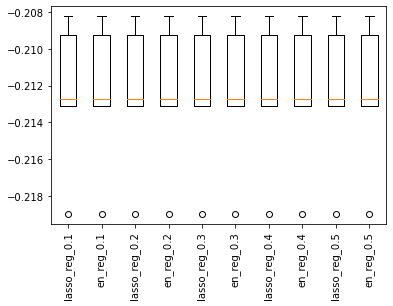

In [53]:
summarize_results(results)

In [58]:
## EN model
en_reg = ElasticNet(alpha=0.01)
en_reg.fit(X_train, y_train)
y_pred_en = en_reg.predict(X_test)
# print('Coefficients: \n', en_reg.coef_)
print(f'Root Mean squared error: {mean_squared_error(y_test, y_pred_en, squared=False)}')
print(f'MASE: {mean_absolute_error(y_test, y_pred_en)}')
print(f'Coefficient of determination R^2: {r2_score(y_test, y_pred_en)}')


Root Mean squared error: 0.15311137228120397
MASE: 0.11059070385584574
Coefficient of determination R^2: 0.4828011661759263


In [59]:
# Lasso model
lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)
# print('Coefficients: \n', lasso_reg.coef_)
print(f'Mean squared error: {mean_squared_error(y_test, y_pred_lasso)}')
print(f'Coefficient of determination R^2: {r2_score(y_test, y_pred_lasso)}')

Mean squared error: 0.045375315746765885
Coefficient of determination R^2: -0.0010650500561206755


In [56]:
X_train_df = pd.DataFrame(X_train, columns=feature_names_nodrop[1:])
# X_train_df.head()
X0_train = sm.add_constant(X_train_df)
model = sm.regression.linear_model.OLS(y_train, X0_train)
res = model.fit_regularized(method='sqrt_lasso', alpha=0.1, L1_wt=1.0)

In [57]:
res.params

numerical__year                0.651839
numerical__odometer           -0.449480
numerical__F1                  0.048428
numerical__F2                 -0.005495
numerical__F3                  0.117700
categorical__x0_ford          -0.047372
categorical__x0_subaru         0.011644
categorical__x1_excellent      0.002187
categorical__x1_fair          -0.025140
categorical__x1_good          -0.003541
categorical__x1_like new       0.026995
categorical__x2_4 cylinders   -0.081095
categorical__x2_6 cylinders    0.000003
categorical__x2_8 cylinders    0.026254
categorical__x3_gas           -0.000010
categorical__x4_automatic     -0.049027
categorical__x4_manual         0.011896
categorical__x5_SUV           -0.077874
categorical__x5_pickup         0.039287
categorical__x5_sedan         -0.132515
categorical__x5_truck          0.023952
categorical__x6_black          0.013025
categorical__x6_blue           0.000013
categorical__x6_red            0.010143
categorical__x6_silver        -0.003814


The Senior Developer took you aside and said: “My task is to deploy your model to
production. But I cannot deploy a paper-report. I need your code. However, remember that I am
not a Data Scientist list you. I have a different expertise. I will read your code, but you should
make sure that I can follow and understand it – and that I know how to use it.”


Hint: In the ideal case, people should be able to take your code, run it and recreate all your results. In a less ideal case, it should be a **demonstration of typical run**. The code should **demonstrate your approach end-to-end**. People should just specify the path to the dataset, run it and see final results. Another name for this is a technical demo. At your future work, you might be quite often asked to demo your results. People will expect you to present an end-to- end example where you read the raw data, train your model and evaluate the results of the predictions.

# TODO: BEFORE SUBMITTING CODE: 
### remember to remove all comments, change code structure so you didn't copy anyone